In [ ]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mv archive.zip /content/drive/MyDrive/EBMRS

In [ ]:
# !kaggle datasets download -d deadskull7/fer2013
#https://www.kaggle.com/msambare/fer2013

In [ ]:
# !unzip '/content/drive/MyDrive/EBMRS/archive.zip' -d '/content/drive/MyDrive/EBMRS/tt_data'

In [4]:
%cd /content/drive/MyDrive/EBMRS

/content/drive/MyDrive/EBMRS


In [ ]:
pwd

'/content/drive/My Drive/EBMRS'

In [3]:
!ls

emotion.ipynb  emotio_rec  git_emotion.ipynb  tt_data


In [ ]:
# labels: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

(48, 48, 3)
(1, 48, 48, 3)


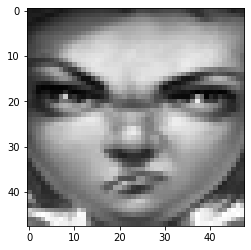

In [6]:
from keras.preprocessing import image
img = image.load_img('tt_data/train/angry/Training_37417413.jpg',target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

# DATA AUGMENTATION

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,        #zoom in the range [1-zoom_range,1+zoom_range]
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [47]:
train_dataset  = train_datagen.flow_from_directory(directory = 'tt_data/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   color_mode = 'grayscale',
                                                   shuffle = True,
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [48]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'tt_data/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  color_mode = 'grayscale',
                                                  batch_size = 64, 
                                                  shuffle = True)

Found 5741 images belonging to 7 classes.


In [49]:
test_dataset = test_datagen.flow_from_directory(directory = 'tt_data/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  color_mode = 'grayscale',
                                                  batch_size = 64, 
                                                  shuffle = True)

Found 7178 images belonging to 7 classes.


In [ ]:
train_img = train_dataset.next()[0]
train_lables = train_dataset.next()[1]
valid_img = valid_dataset.next()[0]
valid_lables = valid_dataset.next()[1]

print(f'shape of the train dataset: {train_img.shape}')
print(f'shape of the train labels: {train_lables.shape}')
print(f'shape of the validation dataset: {train_img.shape}')
print(f'shape of the validation labels: {train_lables.shape}')

shape of the train dataset: (64, 48, 48, 1)
shape of the train labels: (64, 7)
shape of the validation dataset: (64, 48, 48, 1)
shape of the validation labels: (64, 7)


In [ ]:
# base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

# Convolution neural network

In [16]:
'''install the keras-tuner for neural network hyperparameter tuning'''

!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.5MB/s 


In [17]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D

In [18]:
from kerastuner.tuners import Hyperband

In [19]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        kernel_initializer='he_normal',
        activation='relu',
        input_shape=(48,48,1)
    ),

    # keras.layers.BatchNormalization(),
    # keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)),                   

    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        kernel_initializer='he_normal',
        activation='relu'
    ),

    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)),

    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        kernel_initializer='he_normal',
        activation='relu'
    ),

    # keras.layers.BatchNormalization(),
    # keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)),

    keras.layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=64, max_value=256, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        kernel_initializer='he_normal',
        activation='relu'
    ),

    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),

    keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),

    keras.layers.BatchNormalization(),
    keras.layers.Dense(7, activation='softmax')
  ])

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [39]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    hyperband_iterations=3,
    directory='emotio_rec',
    project_name='Facial_rec'
    )


In [27]:
!ls

emotion.ipynb  emotio_rec  git_emotion.ipynb  tt_data


In [41]:
!rm -rf emotio_rec

In [ ]:
tuner.search_space_summary()

In [40]:
tuner.search(train_dataset, epochs = 5, validation_data = valid_dataset,  batch_size = 64)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
conv_1_kernel     |3                 |?                 
conv_2_kernel     |5                 |?                 
conv_3_kernel     |3                 |?                 
conv_4_kernel     |3                 |?                 
dense_1_units     |32                |?                 
dense_2_units     |96                |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |1                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2
 13/359 [>.............................] - ETA: 1:27:44 - loss: 2.3610 - accuracy: 0.1765

KeyboardInterrupt: ignored

In [ ]:
print(tuner.get_best_hyperparameters()[0].values)

{'conv_1_filter': 64, 'conv_1_kernel': 3, 'conv_2_filter': 64, 'conv_2_kernel': 3, 'conv_3_filter': 64, 'conv_3_kernel': 3, 'conv_4_filter': 64, 'conv_4_kernel': 5, 'dense_1_units': 128, 'learning_rate': 0.001, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:
# {'conv_1_filter': 64, 'conv_1_kernel': 3, 'conv_2_filter': 64, 'conv_2_kernel': 3, 'conv_3_filter': 64, 'conv_3_kernel': 3, 'conv_4_filter': 64, 'conv_4_kernel': 5, 'dense_1_units': 128, 'learning_rate': 0.001, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}

In [ ]:
cnn_model = tuner.get_best_models(1)[0]

In [45]:
nb_train_samples = 22968
nb_validation_samples = 5741
epochs=25

In [50]:
history=model.fit_generator(
                train_dataset,
                steps_per_epoch=nb_train_samples//64,
                epochs=25,
                # callbacks=callbacks,
                validation_data=valid_dataset,
                validation_steps=nb_validation_samples//64)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
 18/358 [>.............................] - ETA: 1:59:48 - loss: 2.1432 - accuracy: 0.1884

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.4.1


In [ ]:
'''sparse_softmax_cross_entropy_with_logits'''

# import tensorflow as tf
# with tf.compat.v1.Session() as sess:
#     y = tf.constant([1])
#     x = tf.expand_dims(tf.constant([0.0, 1.0, 0.0]), 0)
#     r = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
#     print(r.eval())
#     print(f'y: {y.shape}')
#     print(f'x: {x.shape}')

In [ ]:
!ls

archive.zip  emotion.ipynb  emotio_rec	tt_data


In [ ]:
%cd /content/drive/My Drive/EBMRS

/content/drive/My Drive/EBMRS


In [ ]:
!ls

emotion.ipynb  git_emotion.ipynb  tt_data


In [ ]:
!rm -rf emotio_rec


# SAVE MODEL 

In [ ]:
cnn_model.save('cnn_model.h5')

In [ ]:
new_model = keras.models.load_model('cnn_model.h5')

In [ ]:
#predict result and find accuracy

y_pred = new_model.predict_classes(df_test_scaled)
print("\n\nThe Test Accuracy of the model is: {} %".format(accuracy_score(y_test, y_pred) * 100.))

# VGG tranfer learning

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt



In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'tt_data/train'
valid_path = 'tt_data/test'

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('tt_data/train/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,        #zoom in the range [1-zoom_range,1+zoom_range]
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)


In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = 'tt_data/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                  #  color_mode = 'grayscale',
                                                   shuffle = True,
                                                   batch_size = 64)


valid_dataset = valid_datagen.flow_from_directory(directory = 'tt_data/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  # color_mode = 'grayscale',
                                                  batch_size = 64, 
                                                  shuffle = True)


test_dataset = test_datagen.flow_from_directory(directory = 'tt_data/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  # color_mode = 'grayscale',
                                                  batch_size = 64, 
                                                  shuffle = True)




Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
'''r=model.fit_generator(train_dataset,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = vlid_dataset,
                         nb_val_samples = 2000)'''

# fit the model
r = model.fit_generator(
  train_dataset,
  validation_data=valid_dataset,
  epochs=5,
  steps_per_epoch=len(train_dataset),
  validation_steps=len(valid_dataset)
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
 37/359 [==>...........................] - ETA: 1:42:12 - loss: 1.9289 - accuracy: 0.2470

KeyboardInterrupt: ignored

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('facefeatures_new_model.h5')

# CNN Model not tunning

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [61]:
def build_model():  
  model = keras.Sequential([
                            
    #block-1                      
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', activation='relu', input_shape=(48,48,1)),
    Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    Dropout(0.25),
    BatchNormalization(),

    #block-2
    Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', activation='relu'),
    Conv2D(filters=256, kernel_size=(3,3), kernel_initializer='he_normal', activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    Dropout(0.25),
    BatchNormalization(),


    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),

    BatchNormalization(),
    Dense(7, activation='softmax')
  ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [62]:
cnn_model = build_model()

In [63]:
nb_train_samples = 22968
nb_validation_samples = 5741
epochs=25

In [ ]:
history=cnn_model.fit(
                train_dataset,
                steps_per_epoch=nb_train_samples//64,
                epochs=25,
                # callbacks=callbacks,
                validation_data=valid_dataset,
                validation_steps=nb_validation_samples//64)


Epoch 1/25
 13/358 [>.............................] - ETA: 1:42:30 - loss: 1.9476 - accuracy: 0.2236